In [0]:
#import modules we need to use for this session
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score

# Task 1. House price prediction using 311 data

### Can 311 complaining profile of urban neighborhoods enhance real-estate price prediction?

[Zhu, E., & Sobolevsky, S. (2018). House Price Modeling with Digital Census. arXiv preprint arXiv:1809.03834.]

Before we tried to use some parameters of the house (size) to predict its price. However notice that location matters as well. Below we upload a sample of more than 14000 individual house sales all around NYC in 2012. Each record together with the parameters of the house also contains important characteristics of the location (zip code) - average income of its residents (accodring to US census), as well as the relative structure of 311 complaints happening in the area.

In [0]:
REsample=pd.read_csv('https://raw.githubusercontent.com/pratikwatwani/Applied-Data-Science/master/data/NYChome_sales2012.csv',index_col=0)

In [389]:
len(REsample)

14611

In [390]:
REsample.head()

,borough,neighborhood,block,lot,easement,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
204018,4,LAURELTON,12941,94,NaN,A2,131-43 FRANCIS LEWIS BLVD,11413,0,3560,1473,1940,0,2012-01-01
217555,2,BATHGATE,3046,42,NaN,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217598,2,BAYCHESTER,4707,70,NaN,A5,1134 EAST 213 STREET,10469,0,2320,1813,1950,335700,2012-05-17
217599,2,BAYCHESTER,4708,48,NaN,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217600,2,BAYCHESTER,4710,1,NaN,A5,1127 EAST 215TH STREET,10469,0,2759,1998,1945,0,2012-12-20


In [391]:
REsample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14611 entries, 204018 to 301573
Data columns (total 14 columns):
borough                   14611 non-null int64
neighborhood              14611 non-null object
block                     14611 non-null int64
lot                       14611 non-null int64
easement                  0 non-null float64
building_class_present    14611 non-null object
address                   14611 non-null object
zip_code                  14611 non-null int64
commmercial_units         14611 non-null int64
land_sq_feet              14611 non-null int64
gross_sq_feet             14611 non-null int64
year_built                14611 non-null int64
sale_price                14611 non-null int64
sale_date                 14611 non-null object
dtypes: float64(1), int64(9), object(4)
memory usage: 1.7+ MB


In [0]:
REsample.drop(columns='easement', inplace = True)

In [393]:
REsample.columns

Index([u'borough', u'neighborhood', u'block', u'lot',
       u'building_class_present', u'address', u'zip_code',
       u'commmercial_units', u'land_sq_feet', u'gross_sq_feet', u'year_built',
       u'sale_price', u'sale_date'],
      dtype='object')

In [394]:
#how many houses do we have per each borough?
np.bincount(REsample.borough)

array([   0,  216,  894, 2769, 7288, 3444])

In [395]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(REsample)) #draw samples within low and high limit, each sample is likely to be drawn 
splitind

array([0.88234931, 0.10432774, 0.90700933, ..., 0.86845249, 0.57514979,
       0.79229244])

In [0]:
REsample1=REsample.loc[splitind<=0.4] #training
REsample2=REsample.loc[(splitind>0.4)&(splitind<0.7)] #validation
REsample3=REsample.loc[(splitind>=0.7)] #test

In [397]:
len(REsample1) #loosing around 50 records within sparse zip codes

5832

In [398]:
len(REsample2)

4394

In [399]:
len(REsample3)

4385

In [0]:
# now load and curate 311 data which we're going to use in order to characterize the location

In [401]:
data311 = pd.read_csv('https://raw.githubusercontent.com/pratikwatwani/Applied-Data-Science/master/data/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [402]:
data311.Zip=pd.to_numeric(data311.Zip,errors='coerce') #Take separate series and convert to numeric, coercing when told to, errors = 'coerce' means then invalid parsing will be set as NaN
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001.0,Adopt-A-Basket,1
3,10003.0,Adopt-A-Basket,1
4,10009.0,Adopt-A-Basket,1
5,10010.0,Adopt-A-Basket,1


In [0]:
data311=data311.loc[(data311.Zip>=10000)&(data311.Zip<11500)] #take only NYC zip codes

In [0]:
data311=pd.pivot_table(data311,index='Zip',columns='Complain',values='Count',fill_value=0)

In [405]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,2,0,0,0,0,1,3,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,2,51,2,1,0,498,1,0,33,3,0,0,3,1,3,394,18,0,5,2,7,7,4,7,3,108,0,7,1,98,...,2,7,71,49,29,9,38,0,38,0,0,0,5,0,429,4,14,1,16,0,1,0,707,39,1,0,0,0,0,0,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,8,73,8,0,24,921,2,0,120,4,2,0,4,2,0,167,4,4,9,5,30,14,20,17,8,144,4,14,1,0,...,19,2,102,50,27,7,26,0,65,0,0,1,8,0,408,296,32,8,14,1,4,4,368,28,319,0,0,1,0,7,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,14,69,16,0,0,1461,1,0,67,4,4,2,4,3,3,181,4,3,17,5,45,11,33,17,16,162,5,21,0,25,...,17,5,115,65,21,7,45,0,49,1,0,0,3,1,572,32,10,16,16,0,5,0,600,20,23,0,0,2,1,7,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,1,8,3,0,0,123,0,0,3,0,0,0,2,0,0,55,0,2,2,0,1,1,0,1,1,12,0,0,0,19,...,5,0,32,23,8,1,8,0,3,0,0,0,1,0,133,93,39,17,21,0,0,0,142,10,96,0,1,0,0,0,1,1,0,16,21,0,0,37,0,0


In [406]:
data311.shape

(264, 162)

In [407]:
list_311=list(data311.columns)
list_311[:10]

['APPLIANCE',
 'Adopt-A-Basket',
 'Air Quality',
 'Animal Abuse',
 'Animal Facility - No Permit',
 'Animal in a Park',
 'Asbestos',
 'BEST/Site Safety',
 'Beach/Pool/Sauna Complaint',
 'Bike Rack Condition']

In [408]:
Total311=data311.sum(axis=1) #total 311 activity per zip code
Total311.head()

Zip
10000.0      114
10001.0     6829
10002.0    11276
10003.0    11269
10004.0     1540
dtype: int64

In [409]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0,0,1,0,0,1,0,0,0,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,1,2,0,0,0,0,1,3,0,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,1,0,0,0,16,1,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,0
10001.0,0,1,90,0,0,1,20,36,1,1,2,51,2,1,0,498,1,0,33,3,0,0,3,1,3,394,18,0,5,2,7,7,4,7,3,108,0,7,1,98,...,2,7,71,49,29,9,38,0,38,0,0,0,5,0,429,4,14,1,16,0,1,0,707,39,1,0,0,0,0,0,3,0,2,51,5,5,2,366,0,0
10002.0,15,0,80,0,0,21,18,20,2,6,8,73,8,0,24,921,2,0,120,4,2,0,4,2,0,167,4,4,9,5,30,14,20,17,8,144,4,14,1,0,...,19,2,102,50,27,7,26,0,65,0,0,1,8,0,408,296,32,8,14,1,4,4,368,28,319,0,0,1,0,7,5,1,4,27,14,10,7,324,0,0
10003.0,15,1,143,0,2,44,24,13,2,2,14,69,16,0,0,1461,1,0,67,4,4,2,4,3,3,181,4,3,17,5,45,11,33,17,16,162,5,21,0,25,...,17,5,115,65,21,7,45,0,49,1,0,0,3,1,572,32,10,16,16,0,5,0,600,20,23,0,0,2,1,7,7,11,2,54,25,12,5,318,0,0
10004.0,0,0,15,0,0,4,3,1,0,1,1,8,3,0,0,123,0,0,3,0,0,0,2,0,0,55,0,2,2,0,1,1,0,1,1,12,0,0,0,19,...,5,0,32,23,8,1,8,0,3,0,0,0,1,0,133,93,39,17,21,0,0,0,142,10,96,0,1,0,0,0,1,1,0,16,21,0,0,37,0,0


In [410]:
data311=data311.div(data311.sum(axis=1), axis=0) #normalize activity of various categories within zip code by total
data311=data311.loc[Total311>100] #keep only those zip codes having sufficient activity
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.070175,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.008772,0.017544,0.000000,0.000000,0.000000,0.000000,0.008772,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.008772,0.000000,0.000000,0.000000,0.140351,0.008772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,0.000293,0.007468,0.000293,0.000146,0.000000,0.072924,0.000146,0.0,0.004832,0.000439,0.000000,0.000000,0.000439,0.000146,0.000439,0.057695,0.002636,0.000000,0.000732,0.000293,0.001025,0.001025,0.000586,0.001025,0.000439,0.015815,0.000000,0.001025,0.000146,0.014351,...,0.000293,0.001025,0.010397,0.007175,0.004247,0.001318,0.005565,0.0,0.005565,0.000000,0.0,0.000000,0.000732,0.000000,0.062820,0.000586,0.002050,0.000146,0.002343,0.000000,0.000146,0.000000,0.103529,0.005711,0.000146,0.0,0.000000,0.000000,0.000000,0.000000,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,0.000709,0.006474,0.000709,0.000000,0.002128,0.081678,0.000177,0.0,0.010642,0.000355,0.000177,0.000000,0.000355,0.000177,0.000000,0.014810,0.000355,0.000355,0.000798,0.000443,0.002661,0.001242,0.001774,0.001508,0.000709,0.012770,0.000355,0.001242,0.000089,0.000000,...,0.001685,0.000177,0.009046,0.004434,0.002394,0.000621,0.002306,0.0,0.005764,0.000000,0.0,0.000089,0.000709,0.000000,0.036183,0.026250,0.002838,0.000709,0.001242,0.000089,0.000355,0.000355,0.032636,0.002483,0.028290,0.0,0.000000,0.000089,0.000000,0.000621,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,0.001242,0.006123,0.001420,0.000000,0.000000,0.129648,0.000089,0.0,0.005946,0.000355,0.000355,0.000177,0.000355,0.000266,0.000266,0.016062,0.000355,0.000266,0.001509,0.000444,0.003993,0.000976,0.002928,0.001509,0.001420,0.014376,0.000444,0.001864,0.000000,0.002218,...

In [411]:
len(data311) #only 179 zip codes with reliable data left

179

In [412]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.070175,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.008772,0.017544,0.000000,0.000000,0.000000,0.000000,0.008772,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.008772,0.000000,0.000000,0.000000,0.140351,0.008772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,0.000293,0.007468,0.000293,0.000146,0.000000,0.072924,0.000146,0.0,0.004832,0.000439,0.000000,0.000000,0.000439,0.000146,0.000439,0.057695,0.002636,0.000000,0.000732,0.000293,0.001025,0.001025,0.000586,0.001025,0.000439,0.015815,0.000000,0.001025,0.000146,0.014351,...,0.000293,0.001025,0.010397,0.007175,0.004247,0.001318,0.005565,0.0,0.005565,0.000000,0.0,0.000000,0.000732,0.000000,0.062820,0.000586,0.002050,0.000146,0.002343,0.000000,0.000146,0.000000,0.103529,0.005711,0.000146,0.0,0.000000,0.000000,0.000000,0.000000,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,0.000709,0.006474,0.000709,0.000000,0.002128,0.081678,0.000177,0.0,0.010642,0.000355,0.000177,0.000000,0.000355,0.000177,0.000000,0.014810,0.000355,0.000355,0.000798,0.000443,0.002661,0.001242,0.001774,0.001508,0.000709,0.012770,0.000355,0.001242,0.000089,0.000000,...,0.001685,0.000177,0.009046,0.004434,0.002394,0.000621,0.002306,0.0,0.005764,0.000000,0.0,0.000089,0.000709,0.000000,0.036183,0.026250,0.002838,0.000709,0.001242,0.000089,0.000355,0.000355,0.032636,0.002483,0.028290,0.0,0.000000,0.000089,0.000000,0.000621,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,0.001242,0.006123,0.001420,0.000000,0.000000,0.129648,0.000089,0.0,0.005946,0.000355,0.000355,0.000177,0.000355,0.000266,0.000266,0.016062,0.000355,0.000266,0.001509,0.000444,0.003993,0.000976,0.002928,0.001509,0.001420,0.014376,0.000444,0.001864,0.000000,0.002218,...

In [0]:
#data311.columns  = data311.columns.str.lower()
#data311.columns  =data311.columns.str.split(' ').str.get(0)

In [0]:
#data311.columns  =data311.columns.str.split('-').str.get(0)
#data311.columns  =data311.columns.str.split('/').str.get(0)

In [415]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
Zip,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.070175,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.008772,0.017544,0.000000,0.000000,0.000000,0.000000,0.008772,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.008772,0.000000,0.000000,0.000000,0.140351,0.008772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,0.000293,0.007468,0.000293,0.000146,0.000000,0.072924,0.000146,0.0,0.004832,0.000439,0.000000,0.000000,0.000439,0.000146,0.000439,0.057695,0.002636,0.000000,0.000732,0.000293,0.001025,0.001025,0.000586,0.001025,0.000439,0.015815,0.000000,0.001025,0.000146,0.014351,...,0.000293,0.001025,0.010397,0.007175,0.004247,0.001318,0.005565,0.0,0.005565,0.000000,0.0,0.000000,0.000732,0.000000,0.062820,0.000586,0.002050,0.000146,0.002343,0.000000,0.000146,0.000000,0.103529,0.005711,0.000146,0.0,0.000000,0.000000,0.000000,0.000000,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,0.000709,0.006474,0.000709,0.000000,0.002128,0.081678,0.000177,0.0,0.010642,0.000355,0.000177,0.000000,0.000355,0.000177,0.000000,0.014810,0.000355,0.000355,0.000798,0.000443,0.002661,0.001242,0.001774,0.001508,0.000709,0.012770,0.000355,0.001242,0.000089,0.000000,...,0.001685,0.000177,0.009046,0.004434,0.002394,0.000621,0.002306,0.0,0.005764,0.000000,0.0,0.000089,0.000709,0.000000,0.036183,0.026250,0.002838,0.000709,0.001242,0.000089,0.000355,0.000355,0.032636,0.002483,0.028290,0.0,0.000000,0.000089,0.000000,0.000621,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,0.001242,0.006123,0.001420,0.000000,0.000000,0.129648,0.000089,0.0,0.005946,0.000355,0.000355,0.000177,0.000355,0.000266,0.000266,0.016062,0.000355,0.000266,0.001509,0.000444,0.003993,0.000976,0.002928,0.001509,0.001420,0.014376,0.000444,0.001864,0.000000,0.002218,...

In [0]:
data311.index.rename('zip_code', inplace = True)

In [417]:
data311.head()

Complain,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,Bike/Roller/Skate Chronic,Blocked Driveway,Boilers,Bottled Water,Bridge Condition,Broken Muni Meter,Broken Parking Meter,Building Condition,Building/Use,Bus Stop Shelter Placement,CONSTRUCTION,Calorie Labeling,City Vehicle Placard Complaint,Collection Truck Noise,Construction,Consumer Complaint,Cranes and Derricks,Curb Condition,DOF Parking - Tax Exemption,DPR Internal,Damaged Tree,Dead Tree,Derelict Bicycle,Derelict Vehicle,Derelict Vehicles,Dirty Conditions,Disorderly Youth,Drinking,Drinking Water,EAP Inspection - F59,...,School Maintenance,Senior Center Complaint,Sewer,Sidewalk Condition,Smoking,Snow,Special Enforcement,Special Natural Area District (SNAD),Special Projects Inspection Team (SPIT),Sprinkler - Mechanical,Squeegee,Stalled Sites,Standing Water,Standpipe - Mechanical,Street Condition,Street Light Condition,Street Sign - Damaged,Street Sign - Dangling,Street Sign - Missing,Summer Camp,Sweeping/Missed-Inadequate,Tattooing,Taxi Complaint,Traffic,Traffic Signal Condition,Trans Fat,Transportation Provider Complaint,Unleashed Dog,Unsanitary Animal Facility,Unsanitary Animal Pvt Property,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
zip_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000.0,0.000000,0.000000,0.008772,0.0,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.070175,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.008772,0.017544,0.000000,0.000000,0.000000,0.000000,0.008772,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.008772,0.000000,0.000000,0.000000,0.140351,0.008772,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070175,0.070175,0.000000,0.000000,0.000000,0.0,0.0
10001.0,0.000000,0.000146,0.013179,0.0,0.000000,0.000146,0.002929,0.005272,0.000146,0.000146,0.000293,0.007468,0.000293,0.000146,0.000000,0.072924,0.000146,0.0,0.004832,0.000439,0.000000,0.000000,0.000439,0.000146,0.000439,0.057695,0.002636,0.000000,0.000732,0.000293,0.001025,0.001025,0.000586,0.001025,0.000439,0.015815,0.000000,0.001025,0.000146,0.014351,...,0.000293,0.001025,0.010397,0.007175,0.004247,0.001318,0.005565,0.0,0.005565,0.000000,0.0,0.000000,0.000732,0.000000,0.062820,0.000586,0.002050,0.000146,0.002343,0.000000,0.000146,0.000000,0.103529,0.005711,0.000146,0.0,0.000000,0.000000,0.000000,0.000000,0.000439,0.000000,0.000293,0.007468,0.000732,0.000732,0.000293,0.053595,0.0,0.0
10002.0,0.001330,0.000000,0.007095,0.0,0.000000,0.001862,0.001596,0.001774,0.000177,0.000532,0.000709,0.006474,0.000709,0.000000,0.002128,0.081678,0.000177,0.0,0.010642,0.000355,0.000177,0.000000,0.000355,0.000177,0.000000,0.014810,0.000355,0.000355,0.000798,0.000443,0.002661,0.001242,0.001774,0.001508,0.000709,0.012770,0.000355,0.001242,0.000089,0.000000,...,0.001685,0.000177,0.009046,0.004434,0.002394,0.000621,0.002306,0.0,0.005764,0.000000,0.0,0.000089,0.000709,0.000000,0.036183,0.026250,0.002838,0.000709,0.001242,0.000089,0.000355,0.000355,0.032636,0.002483,0.028290,0.0,0.000000,0.000089,0.000000,0.000621,0.000443,0.000089,0.000355,0.002394,0.001242,0.000887,0.000621,0.028734,0.0,0.0
10003.0,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,0.001242,0.006123,0.001420,0.000000,0.000000,0.129648,0.000089,0.0,0.005946,0.000355,0.000355,0.000177,0.000355,0.000266,0.000266,0.016062,0.000355,0.000266,0.001509,0.000444,0.003993,0.000976,0.002928,0.001509,0.001420,0.014376,0.000444,0.001864,0.000000,0.00221

#### Q1. Run linear regression 'sale_price ~ gross_sq_feet+land_sq_feet+year_built' over the training data

## REsample1 is the training data

In [418]:
REsample1.head()

,borough,neighborhood,block,lot,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date
217555,2,BATHGATE,3046,42,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05
217599,2,BAYCHESTER,4708,48,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03
217605,2,BAYCHESTER,4715,61,A9,1118 221ST STREET,10469,0,2514,1690,1950,250000,2012-12-17
217609,2,BAYCHESTER,4724,21,A1,3453 KINGSLAND AVENUE,10469,0,2283,1588,1910,249600,2012-06-01
217610,2,BAYCHESTER,4725,45,A9,1453 HICKS STREET,10469,0,1710,1690,1945,313000,2012-09-20


In [419]:
REsample1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832 entries, 217555 to 301570
Data columns (total 13 columns):
borough                   5832 non-null int64
neighborhood              5832 non-null object
block                     5832 non-null int64
lot                       5832 non-null int64
building_class_present    5832 non-null object
address                   5832 non-null object
zip_code                  5832 non-null int64
commmercial_units         5832 non-null int64
land_sq_feet              5832 non-null int64
gross_sq_feet             5832 non-null int64
year_built                5832 non-null int64
sale_price                5832 non-null int64
sale_date                 5832 non-null object
dtypes: int64(9), object(4)
memory usage: 637.9+ KB


In [420]:
lm  = smf.ols(formula = 'sale_price ~ gross_sq_feet+land_sq_feet+year_built', data = REsample1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     342.8
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          5.23e-205
Time:                        02:58:19   Log-Likelihood:                -88308.
No. Observations:                5832   AIC:                         1.766e+05
Df Residuals:                    5828   BIC:                         1.767e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.637e+06   8.92e+05      8.561

In [421]:
print('The R2 Score over Training Data is: {}'.format(r2_score(REsample1.sale_price, lm.predict())))

The R2 Score over Training Data is: 0.149987575604


#### Q2. Add 311 data corresponding to the zip code of the house location to REsample1,2,3 
in order to characterize the house's neighborhood by merging the dataframes REsample1,2,3 with data311 by zip code. Name merged dataframes REsample1_311, REsample2_311, REsample3_311 
rename 311 columns to F1,F2,... for easier formulae engineering
but keep the original names as a dictionary {'F1':'APPLIANCE', ...}

In [0]:
data311.columns = ['F%d'%p for p in range(0,len(data311.columns))]

In [0]:
REsample1_311 = REsample1.merge(data311, on = 'zip_code')
REsample2_311 = REsample2.join(data311, on = 'zip_code')
REsample3_311 = REsample3.join(data311, on = 'zip_code')

#### Q3. Run the linear model with 311
We need to add 311 features in addition to the gross_sq_feet,land_sq_feet,year_built used before. So regression will include both - house characteristics as well as 311 features of the location
Train the model over the training sample REsample1_311 and test over the test sample REsample3_311,
report training and test R2

In [424]:
REsample1_311.head()

,borough,neighborhood,block,lot,building_class_present,address,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,sale_price,sale_date,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,...,F122,F123,F124,F125,F126,F127,F128,F129,F130,F131,F132,F133,F134,F135,F136,F137,F138,F139,F140,F141,F142,F143,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
0,2,BATHGATE,3046,42,A1,2069 BATHGATE AVE,10457,0,1964,1424,1899,345376,2012-04-05,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,0.000321,0.0,0.0,0.000054,0.014878,0.001659,0.0,0.000000,0.001124,0.0,0.0,0.007279,0.000054,0.000589,0.0,0.0,0.0,0.000054,0.007332,0.0,...,0.001713,0.0,0.006048,0.000749,0.000375,0.000268,0.001873,0.0,0.000375,0.0,0.0,0.000107,0.000161,0.0,0.013647,0.007332,0.000589,0.000268,0.000535,0.0,0.000107,0.000107,0.000428,0.000535,0.002622,0.0,0.0,0.000107,0.0,0.001124,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
1,2,MOUNT HOPE/MOUNT EDEN,2790,53,A1,1693 CLAY AVENUE,10457,0,3610,1998,1901,168324,2012-06-28,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,0.000321,0.0,0.0,0.000054,0.014878,0.001659,0.0,0.000000,0.001124,0.0,0.0,0.007279,0.000054,0.000589,0.0,0.0,0.0,0.000054,0.007332,0.0,...,0.001713,0.0,0.006048,0.000749,0.000375,0.000268,0.001873,0.0,0.000375,0.0,0.0,0.000107,0.000161,0.0,0.013647,0.007332,0.000589,0.000268,0.000535,0.0,0.000107,0.000107,0.000428,0.000535,0.002622,0.0,0.0,0.000107,0.0,0.001124,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
2,2,MOUNT HOPE/MOUNT EDEN,2791,36,A1,1690 MONROE AVENUE,10457,0,2375,1617,1910,250000,2012-12-28,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,0.000321,0.0,0.0,0.000054,0.014878,0.001659,0.0,0.000000,0.001124,0.0,0.0,0.007279,0.000054,0.000589,0.0,0.0,0.0,0.000054,0.007332,0.0,...,0.001713,0.0,0.006048,0.000749,0.000375,0.000268,0.001873,0.0,0.000375,0.0,0.0,0.000107,0.000161,0.0,0.013647,0.007332,0.000589,0.000268,0.000535,0.0,0.000107,0.000107,0.000428,0.000535,0.002622,0.0,0.0,0.000107,0.0,0.001124,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
3,2,MOUNT HOPE/MOUNT EDEN,2802,33,A1,258 MOUNT HOPE PLACE,10457,0,2375,1825,1905,211000,2012-08-17,0.007921,0.0,0.001980,0.002087,0.000000,0.000589,0.000321,0.000321,0.0,0.0,0.000054,0.014878,0.001659,0.0,0.000000,0.001124,0.0,0.0,0.007279,0.000054,0.000589,0.0,0.0,0.0,0.000054,0.007332,0.0,...,0.001713,0.0,0.006048,0.000749,0.000375,0.000268,0.001873,0.0,0.000375,0.0,0.0,0.000107,0.000161,0.0,0.013647,0.007332,0.000589,0.000268,0.000535,0.0,0.000107,0.000107,0.000428,0.000535,0.002622,0.0,0.0,0.000107,0.0,0.001124,0.000161,0.000268,0.000321,0.000428,0.000482,0.000803,0.000268,0.028311,0.000000,0.0
4,2,BAYCHESTER,4708,48,A5,1110 EAST 214TH STREET,10469,0,1710,1813,1945,338000,2012-02-03,0.004757,0.0,0.001822,0.003643,0.000101,0.000405,0.001316,0.000607,0.0,0.0,0.000405,0.070337,0.001012,0.0,0.000101,0.002935,0.0,0.0,0.021455,0.000304,0.000708,0.0,0.0,0.0,0.000101,0.010120,0.0,...,0.000101,0.0,0.026010,0.002024,0.000607,0.001316,0.005060,0.0,0.000911,0.0,0.0,0.000000,0.002125,0.0,0.035624,0.086428,0.003441,0.001316,0.004655,0.0,0.001417,0.000000,0.000405,0.001012,0.011234,0.0,0.0,0.000810,0.0,0.003036,0.000405,0.000202,0.001619,0.000202,0.000101,0.004959,0.000708,0.046250,0.000101,0.0


In [425]:
'sale_price ~ gross_sq_feet+land_sq_feet+year_built'+'+'+'+'.join(REsample1_311.columns[(len(REsample1_311.columns)-len(data311.columns)):])

'sale_price ~ gross_sq_feet+land_sq_feet+year_built+F0+F1+F2+F3+F4+F5+F6+F7+F8+F9+F10+F11+F12+F13+F14+F15+F16+F17+F18+F19+F20+F21+F22+F23+F24+F25+F26+F27+F28+F29+F30+F31+F32+F33+F34+F35+F36+F37+F38+F39+F40+F41+F42+F43+F44+F45+F46+F47+F48+F49+F50+F51+F52+F53+F54+F55+F56+F57+F58+F59+F60+F61+F62+F63+F64+F65+F66+F67+F68+F69+F70+F71+F72+F73+F74+F75+F76+F77+F78+F79+F80+F81+F82+F83+F84+F85+F86+F87+F88+F89+F90+F91+F92+F93+F94+F95+F96+F97+F98+F99+F100+F101+F102+F103+F104+F105+F106+F107+F108+F109+F110+F111+F112+F113+F114+F115+F116+F117+F118+F119+F120+F121+F122+F123+F124+F125+F126+F127+F128+F129+F130+F131+F132+F133+F134+F135+F136+F137+F138+F139+F140+F141+F142+F143+F144+F145+F146+F147+F148+F149+F150+F151+F152+F153+F154+F155+F156+F157+F158+F159+F160+F161'

In [426]:
#resample1311preds = [[] for i in range(REsample1_311.shape[0])]
#formula = 'sale_price ~ gross_sq_feet+land_sq_feet+year_built'+'+'+'+'.join(REsample1_311.columns[14:])

lms  = smf.ols(formula = 'sale_price ~ gross_sq_feet+land_sq_feet+year_built'+'+'+'+'.join(REsample1_311.columns[(len(REsample1_311.columns)-len(data311.columns)):]), data = REsample1_311).fit()
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     30.23
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        02:58:20   Log-Likelihood:                -85271.
No. Observations:                5710   AIC:                         1.708e+05
Df Residuals:                    5560   BIC:                         1.718e+05
Df Model:                         149                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.873e+08    6.1e+07     -3.071

In [427]:
#R2 over training
print("R2_Score for Training Data: {}".format(r2_score(REsample1_311.sale_price, lms.predict())))

R2_Score for Training Data: 0.447555858667


In [428]:
print("R2 over Testing is {}".format(((REsample3_311.sale_price-lm.predict(REsample3_311))**2).sum()/((REsample3_311.sale_price-REsample3_311.sale_price.mean())**2).sum()))

R2 over Testing is 0.842285385246


#### Q4. Apply regularization
Train Ridge and Lasso over REsample1_311 with an arbitrary default parameter $\alpha=1$.
Then evaluate their out-of-sample performance over REsample3_311
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [429]:
num_cols = REsample1_311.columns[REsample1_311.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
REsample1_311[num_cols] = preprocessing.scale(REsample1_311[num_cols])

num_cols1 = REsample2_311.columns[REsample2_311.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
REsample2_311[num_cols1] = preprocessing.scale(REsample2_311[num_cols1])

num_cols2 = REsample3_311.columns[REsample3_311.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
REsample3_311[num_cols2] = preprocessing.scale(REsample3_311[num_cols2])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [0]:
train_y = REsample1_311.sale_price
validate_y = REsample2_311.sale_price
test_y = REsample3_311.sale_price

string_cols = (REsample.dtypes[REsample.dtypes == "object"].index).to_list()
string_cols.append('sale_price')

REsample1_311.drop(labels = string_cols, axis = 1, inplace = True)
REsample2_311.drop(labels = string_cols, axis = 1, inplace = True)
REsample3_311.drop(labels = string_cols, axis = 1, inplace = True)

In [431]:
string_cols = (REsample.dtypes[REsample.dtypes == "object"].index).to_list()
string_cols

['neighborhood', 'building_class_present', 'address', 'sale_date']

In [0]:
#learn standardization parameters from training set
mu=REsample1_311.mean()
sigma=REsample1_311.std()

In [0]:
REsample1_311=(REsample1_311-mu)/sigma
REsample2_311=(REsample2_311-mu)/sigma
REsample3_311=(REsample3_311-mu)/sigma

In [434]:
REsample3_311.head()

,borough,block,lot,zip_code,commmercial_units,land_sq_feet,gross_sq_feet,year_built,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,...,F122,F123,F124,F125,F126,F127,F128,F129,F130,F131,F132,F133,F134,F135,F136,F137,F138,F139,F140,F141,F142,F143,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
204018,0.146440,1.769788,0.189112,0.798964,-0.152782,0.011214,-0.314115,-0.106974,-0.181534,-0.325146,-0.204811,-0.240005,-0.490565,0.029389,-1.045853,-0.194280,-0.581457,-0.306536,0.835753,-0.411898,-0.293284,2.475118,-0.313225,-0.845083,-0.440766,-0.050394,0.674627,-0.536975,-0.668734,-0.230764,-0.057774,-0.593717,0.905292,-0.356040,-0.389834,-0.439722,-0.115135,-0.388944,0.486308,0.421074,...,-0.102554,-0.548949,0.676170,-0.591996,-0.922094,-0.814521,0.194722,-0.082192,-0.391411,-0.047825,-0.04574,-0.304966,-0.339745,-0.03095,0.006264,1.256053,-0.694506,0.570396,0.214421,-0.155263,-0.562516,-0.327908,-0.24650,0.431810,0.013083,-0.14213,-0.23921,0.044947,-0.329957,-1.275897,-1.099176,-0.916984,0.363629,-0.723355,-0.390859,0.293941,0.042063,0.807594,-0.288045,-0.221131
217598,-2.102729,-0.447064,0.012213,-1.164280,-0.152782,-0.332694,0.045796,0.279865,1.601651,-0.325146,-0.391372,3.554909,0.113260,-0.399887,0.421641,0.285915,-0.581457,-0.306536,1.064598,0.603636,0.149039,-0.205982,0.196976,-0.690710,-0.440766,-0.050394,-0.409709,0.215488,0.502161,-0.230764,-0.762647,-0.593717,-0.792877,0.039679,-0.389834,0.067906,0.079155,-0.069270,-0.815457,-0.541258,...,-1.191977,-0.548949,-0.827594,-0.536829,-0.127754,-0.369604,-0.270494,-0.428763,-0.286440,-0.047825,-0.04574,-0.304966,-0.396833,-0.03095,-1.030632,0.733302,-0.651096,-0.683625,0.102163,-0.155263,0.526140,-0.327908,-0.32381,-0.792252,-1.128791,-0.14213,-0.23921,-0.075507,-0.329957,1.045482,-0.106514,-0.021935,-0.563932,-0.596083,-0.443247,-0.064835,-0.772323,-0.149899,1.188412,-0.221131
217602,-2.102729,-0.445987,0.203854,-1.164280,-0.152782,-0.422831,-0.072763,0.279865,1.601651,-0.325146,-0.391372,3.554909,0.113260,-0.399887,0.421641,0.285915,-0.581457,-0.306536,1.064598,0.603636,0.149039,-0.205982,0.196976,-0.690710,-0.440766,-0.050394,-0.409709,0.215488,0.502161,-0.230764,-0.762647,-0.593717,-0.792877,0.039679,-0.389834,0.067906,0.079155,-0.069270,-0.815457,-0.541258,...,-1.191977,-0.548949,-0.827594,-0.536829,-0.127754,-0.369604,-0.270494,-0.428763,-0.286440,-0.047825,-0.04574,-0.304966,-0.396833,-0.03095,-1.030632,0.733302,-0.651096,-0.683625,0.102163,-0.155263,0.526140,-0.327908,-0.32381,-0.792252,-1.128791,-0.14213,-0.23921,-0.075507,-0.329957,1.045482,-0.106514,-0.021935,-0.563932,-0.596083,-0.443247,-0.064835,-0.772323,-0.149899,1.188412,-0.221131
217604,-2.102729,-0.444910,-0.090977,-1.164280,-0.152782,-0.332694,-0.084407,0.279865,1.601651,-0.325146,-0.391372,3.554909,0.113260,-0.399887,0.421641,0.285915,-0.581457,-0.306536,1.064598,0.603636,0.149039,-0.205982,0.196976,-0.690710,-0.440766,-0.050394,-0.409709,0.215488,0.502161,-0.230764,-0.762647,-0.593717,-0.792877,0.039679,-0.389834,0.067906,0.079155,-0.069270,-0.815457,-0.541258,...,-1.191977,-0.548949,-0.827594,-0.536829,-0.127754,-0.369604,-0.270494,-0.428763,-0.286440,-0.047825,-0.04574,-0.304966,-0.396833,-0.03095,-1.030632,0.733302,-0.651096,-0.683625,0.102163,-0.155263,0.526140,-0.327908,-0.32381,-0.792252,-1.128791,-0.14213,-0.23921,-0.075507,-0.329957,1.045482,-0.106514,-0.021935,-0.563932,-0.596083,-0.443247,-0.064835,-0.772323,-0.149899,1.188412,-0.221131
217606,-2.102729,-0.444372,-0.312100,-1.164280,-0.152782,0.341255,0.666113,-0.493814,1.601651,-0.325146,-0.391372,3.554909,0.113260,-0.399887,0.421641,0.285915,-0.581457,-0.306536,1.064598,0.603636,0.149039,-0.205982,0.196976,-0.690710,-0.440766,-0.050394,-0.409709,0.215488,0.502161,-0.230764,-0.762647,-0.593717,-0.792877,0.039679,-0.389834,0.067906,0.079155,-0.069270,-0.815457,-0.541258,...,-1.191977,-0.548949,-0.827594,-0.536829,-0.127754,-0.369604,-0.

In [0]:
al = REsample1_311.copy()
ab = REsample3_311.copy()


al.fillna(inplace = True, value = 0, axis = 0)
ab.fillna(inplace = True, value = 0, axis = 0)

In [436]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=1)
Ridge.fit(al, train_y)

R_isample_train=Ridge.predict(al)
print("The IS R-squared of Ridge is: {0}".format(r2_score(train_y,R_isample_train)))


R_osample_test=Ridge.predict(ab)
print("The 0S R-squared of Ridge is: {}".format(r2_score(test_y,R_osample_test)))
print('Ridge coef: {}'.format(Ridge.coef_[0]))

The IS R-squared of Ridge is: 0.448843712587
The 0S R-squared of Ridge is: 0.298337499307
Ridge coef: 0.208882822282


# Perform Lasso

In [437]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=1)
Lasso.fit(al,train_y)

L_isample_train=Lasso.predict(al)
print("The IS R-squared of Lasso is: {0}".format(r2_score(train_y,L_isample_train)))

L_osample_test=Lasso.predict(ab)
print("The OS R-squared of Lasso is: {0}".format(r2_score(test_y, L_osample_test)))
print('Lasso coef: {}'.format(Lasso.coef_[0]))

The IS R-squared of Lasso is: 0.0
The OS R-squared of Lasso is: 0.0
Lasso coef: -0.0


#### Q5. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range -exp(10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set

In [0]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #aplhas: a list of aplha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's
    
    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []
    
    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_
    
    if Graph==True: #visualization of the performance depending on alpha
        plt.figure(figsize = (15,10))
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return [best_alpha,best_R2,best_coefs]

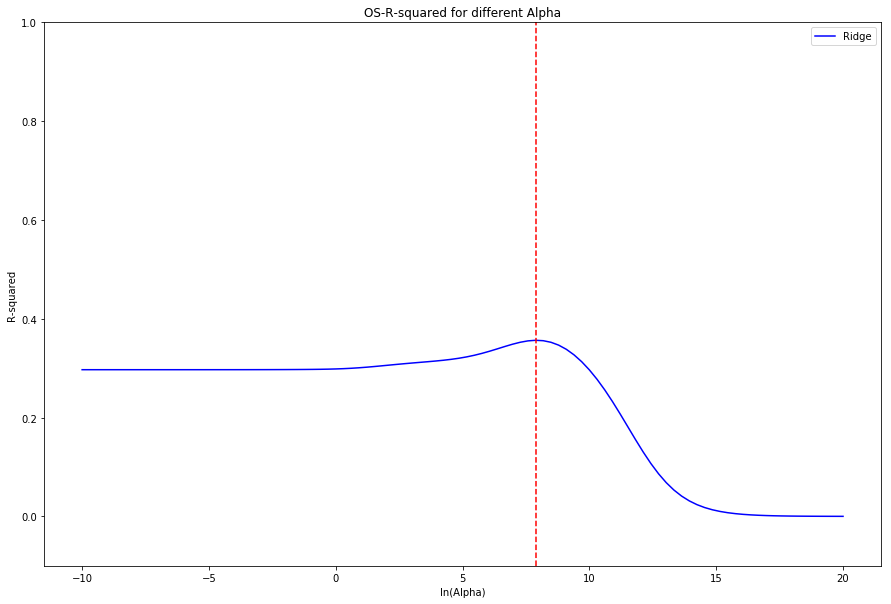

Optimal alpha for Ridge=2640.66980715, best OS R_2=0.356317130417


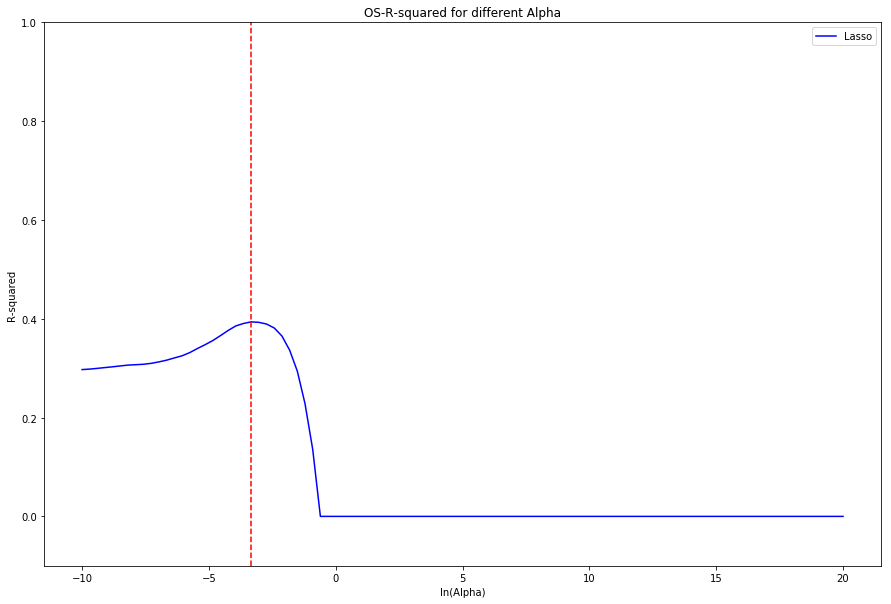

Optimal alpha for Lasso=0.0356739933473, best OS R_2=0.393607154431


In [439]:
alphas = np.exp(np.linspace(-10.0,20.0,100)) 
for x in range(1,3):
  if x ==1:
    [alpha_optimalR, best_R2R, best_coefsR]=Regularization_fit_alpha(x,al,train_y,ab, test_y,alphas,Graph=True,logl=True)
    print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimalR,best_R2R))
  else:
    [alpha_optimalL, best_R2L, best_coefsL]=Regularization_fit_alpha(x,al,train_y,ab, test_y,alphas,Graph=True,logl=True)
    print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimalL,best_R2L))

In [0]:
#now consider the test sample performanc of the best Lasso model and its coefficients

In [441]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimalL)

Lasso.fit(al,train_y)
YPred_IS=Lasso.predict(al)
print("The IS R-squared of Lasso is: {0}".format(r2_score(train_y,YPred_IS)))


YPred_OS=Lasso.predict(ab)
print("The OS R-squared of Lasso is: {0}".format(r2_score(test_y,YPred_OS)))
print('The Lasso coef is {}'.format(Lasso.coef_[0]))

The IS R-squared of Lasso is: 0.355485641593
The OS R-squared of Lasso is: 0.393607154431
The Lasso coef is -0.0


In [442]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimalR)
Ridge.fit(al, train_y)


YPred_IS=Ridge.predict(al)
print("The IS R-squared of Ridge is: {0}".format(r2_score(train_y,YPred_IS)))


YPred_OS=Ridge.predict(ab)
print("The OS R-squared of Lasso is: {0}".format(r2_score(test_y,YPred_OS)))
print('The Ridge coef is {}'.format(Ridge.coef_[0]))

The IS R-squared of Ridge is: 0.376834912159
The OS R-squared of Lasso is: 0.356317130417
The Ridge coef is -0.0278187620844


#### Task 2. Model Mean income of the zip code population using 311 profile of the neighborhood

In [464]:
#load the data
dataIncome=pd.read_csv("https://raw.githubusercontent.com/pratikwatwani/Applied-Data-Science/master/data/MeanZIP.csv",index_col=0)
dataIncome=dataIncome.apply(pd.to_numeric, errors='coerce')
dataIncome=dataIncome.loc[dataIncome.Mean>0]
dataIncome.head()

,Median,Mean,Pop
Zip,,,
1001,56662.5735,66687.7509,16445
1002,49853.4177,75062.6343,28069
1003,28462.0000,35121.0000,8491
1005,75423.0000,82442.0000,4798
1007,79076.3540,85801.9750,12962


In [465]:
dataIncome.isna().values.any()

False

In [466]:
dataIncome = dataIncome.iloc[:,[1,0,2]]
dataIncome.head()

,Mean,Median,Pop
Zip,,,
1001,66687.7509,56662.5735,16445
1002,75062.6343,49853.4177,28069
1003,35121.0000,28462.0000,8491
1005,82442.0000,75423.0000,4798
1007,85801.9750,79076.3540,12962


In [0]:
dataIncome.index.rename('zip_code', inplace = True)

In [0]:
#split into training (1), validation (2) and test (3) samples
np.random.seed(2018)
splitind=np.random.uniform(size=len(dataIncome))
dataIncome1=dataIncome.loc[splitind<=0.4]
dataIncome2=dataIncome.loc[(splitind>0.4)&(splitind<0.7)]
dataIncome3=dataIncome.loc[(splitind>=0.7)]

In [469]:
dataIncome1.isna().values.any()

False

In [0]:
train = dataIncome1.merge(data311, on = 'zip_code') #Training
validation = dataIncome2.merge(data311, on = 'zip_code') #Validation
test = dataIncome3.merge(data311, on = 'zip_code') #Testing

In [471]:
train.isna().values.any()

False

#### Q1. Perform regularied regression of Mean income of the zip code vs its 311 profile 
Train Ridge and Lasso over dataIncome1 with an arbitrary default parameter $\alpha=100$.
Then evaluate their out-of-sample performance over dataIncome3
Make sure to scale the features in all three samples first, learning the scaler over the training sample

In [472]:
train.head()

,Mean,Median,Pop,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,...,F122,F123,F124,F125,F126,F127,F128,F129,F130,F131,F132,F133,F134,F135,F136,F137,F138,F139,F140,F141,F142,F143,F144,F145,F146,F147,F148,F149,F150,F151,F152,F153,F154,F155,F156,F157,F158,F159,F160,F161
zip_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10003,139330.9968,89998.5339,53609,0.001331,0.000089,0.012690,0.0,0.000177,0.003905,0.002130,0.001154,0.000177,0.000177,0.001242,0.006123,0.001420,0.0,0.0,0.129648,0.000089,0.0,0.005946,0.000355,0.000355,0.000177,0.000355,0.000266,0.000266,0.016062,0.000355,0.000266,0.001509,0.000444,0.003993,0.000976,0.002928,0.001509,0.001420,0.014376,0.000444,...,0.001509,0.000444,0.010205,0.005768,0.001864,0.000621,0.003993,0.0,0.004348,0.000089,0.0,0.0,0.000266,0.000089,0.050759,0.002840,0.000887,0.001420,0.001420,0.0,0.000444,0.000000,0.053243,0.001775,0.002041,0.0,0.0,0.000177,0.000089,0.000621,0.000621,0.000976,0.000177,0.004792,0.002218,0.001065,0.000444,0.028219,0.000000,0.0
10005,163762.6601,115133.2855,1517,0.000000,0.000000,0.008219,0.0,0.000000,0.002192,0.000548,0.001644,0.000000,0.000000,0.001096,0.000548,0.000000,0.0,0.0,0.138082,0.000548,0.0,0.003836,0.000000,0.000000,0.000000,0.000548,0.000000,0.000000,0.015890,0.000548,0.000000,0.001096,0.000000,0.000000,0.001644,0.000548,0.000000,0.000548,0.007671,0.000000,...,0.000000,0.000000,0.009863,0.020822,0.004384,0.000000,0.006027,0.0,0.003288,0.000000,0.0,0.0,0.000000,0.000000,0.087671,0.051507,0.021918,0.010411,0.007123,0.0,0.000000,0.000000,0.062466,0.000000,0.033973,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.000548,0.000000,0.019726,0.000000,0.0
10006,156776.0000,111220.0000,972,0.000000,0.000000,0.016667,0.0,0.000000,0.000000,0.003846,0.003846,0.000000,0.000000,0.000000,0.005128,0.000000,0.0,0.0,0.020513,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014103,0.005128,0.000000,0.000000,0.000000,0.001282,0.000000,0.000000,0.001282,0.000000,0.003846,0.000000,...,0.005128,0.000000,0.015385,0.035897,0.000000,0.000000,0.003846,0.0,0.002564,0.000000,0.0,0.0,0.000000,0.000000,0.087179,0.028205,0.034615,0.007692,0.008974,0.0,0.000000,0.000000,0.066667,0.010256,0.033333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.001282,0.000000,0.008974,0.000000,0.001282,0.001282,0.032051,0.000000,0.0
10009,78138.2679,56615.2777,56975,0.001972,0.000104,0.010275,0.0,0.000000,0.000727,0.002180,0.001661,0.000311,0.000311,0.002906,0.009030,0.001972,0.0,0.0,0.031240,0.000104,0.0,0.007473,0.000830,0.000727,0.000000,0.000415,0.000000,0.000000,0.006331,0.000104,0.000000,0.001142,0.000104,0.002906,0.002076,0.004255,0.001972,0.001972,0.018474,0.000311,...,0.000415,0.000000,0.010483,0.003736,0.001661,0.000104,0.001972,0.0,0.003944,0.000000,0.0,0.0,0.001245,0.000000,0.032590,0.001349,0.000519,0.000104,0.000830,0.0,0.000519,0.000208,0.029683,0.001038,0.000830,0.0,0.0,0.000415,0.000000,0.000623,0.000623,0.000727,0.000934,0.007265,0.000623,0.000311,0.001038,0.033420,0.000104,0.0
10012,135998.6472,81316.7066,26464,0.000562,0.000844,0.011389,0.0,0.000000,0.001265,0.002812,0.001406,0.000000,0.000281,0.000703,0.002250,0.001969,0.0,0.0,0.027559,0.000000,0.0,0.014061,0.000000,0.001406,0.000000,0.000141,0.000562,0.000422,0.015748,0.000422,0.000000,0.000281,0.000000,0.003093,0.001265,0.002812,0.001125,0.001406,0.023622,0.000000,...,0.000000,0.000422,0.012655,0.005062,0.001406,0.000141,0.003937,0.0,0.006046,0.000000,0.0,0.0,0.000141,0.000000,0.023903,0.012092,0.001125,0.000562,0.002109,0.0,0.000141,0.000000,0.049494,0.008436,0.020669,0.0,0.0,0.000141,0.000000,0.000141,0.000422,0.000281,0.000141,0.019263,0.000281,0.000562,0.000703,0.029246,0.000000,0.0


In [0]:
mu=train.iloc[:,1:].mean()
sigma=train.iloc[:,1].std()

In [0]:
train.iloc[:,1:]=(train.iloc[:,1:]-mu)/sigma
validation.iloc[:,1:]=(train.iloc[:,1:]-mu)/sigma
test.iloc[:,1:]=(train.iloc[:,1:]-mu)/sigma

In [453]:
'''
y = train['Mean']
train.drop(columns='Mean', inplace = True)

y1 = validation['Mean']
validation.drop(columns='Mean', inplace = True)

y2 = test['Mean']
test.drop(columns='Mean', inplace = True)
'''


"\ny = train['Mean']\ntrain.drop(columns='Mean', inplace = True)\n\ny1 = validation['Mean']\nvalidation.drop(columns='Mean', inplace = True)\n\ny2 = test['Mean']\ntest.drop(columns='Mean', inplace = True)\n"

In [0]:
'''
train.fillna(value = 0, axis = 0, inplace = True)
train.dropna(how = 'any', inplace = True)
validation.dropna(how = 'any', inplace = True)
test.dropna(how = 'any', inplace = True)
'''
validation.fillna(value = 0, axis = 0, inplace = True)
test.fillna(value = 0, axis = 0, inplace = True)

In [455]:
'''
validation.replace([np.inf, -np.inf], np.nan)
validation.dropna(how = 'any', inplace = True)
''' 

"\nvalidation.replace([np.inf, -np.inf], np.nan)\nvalidation.dropna(how = 'any', inplace = True)\n"

In [479]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=100)

Lasso.fit(train.iloc[:,1:],train['Mean'])
isample=Lasso.predict(train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(train['Mean'],isample)))

osample=Lasso.predict(test.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(test['Mean'],osample)))
Lasso.coef_[:10]

The IS R-squared of Lasso is: 0.900934134523
The OS R-squared of Lasso is: -0.271847767895


array([43438.17894077,  2176.00924491,     0.        ,     0.        ,
           0.        ,     0.        ,    -0.        ,     0.        ,
           0.        ,     0.        ])

In [480]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=100)
Ridge.fit(train.iloc[:,1:],train['Mean'])

isample=Ridge.predict(train.iloc[:,1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(train['Mean'],isample)))

osample=Ridge.predict(test.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(test['Mean'],osample)))
Ridge.coef_[:10]

The IS R-squared of Ridge is: 0.602231866761
The OS R-squared of Lasso is: -0.271847767895


array([ 1.78325617e+04, -2.48965961e+03, -7.73244912e-04,  8.33046309e-06,
        3.23957066e-03, -2.62630418e-04,  9.26409124e-06,  8.76233110e-04,
        4.55988350e-04,  3.85090006e-04])

#### Q2. Perform parameter selection for Lasso and Ridge over validation sample
try exponential range exp(-10)...exp(20) with 100 values in it

Visualize the validation R2 vs alpha

For the optimal alpha evaluate performance of the models over the test set. 

Why do you think performance does not look that good, especially for one of the models?

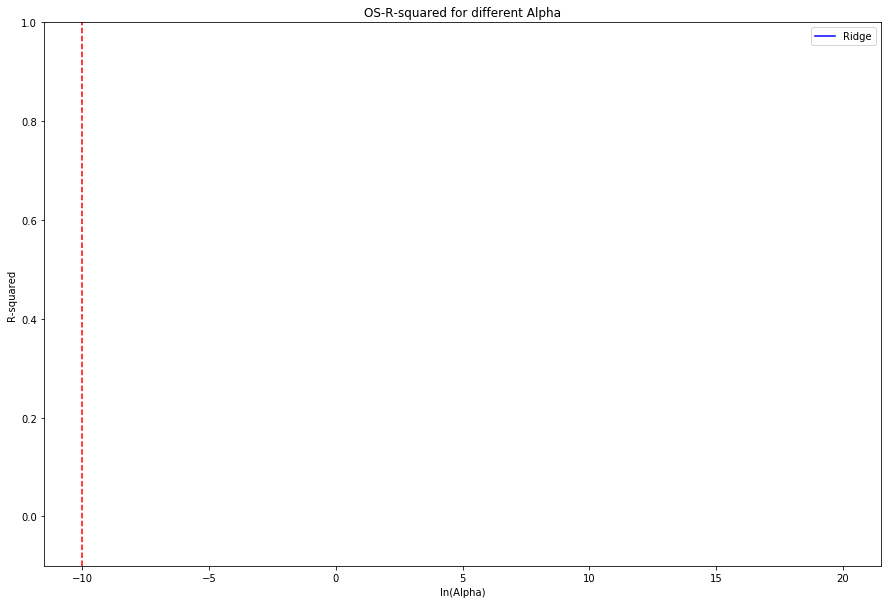

Optimal alpha for Ridge=4.53999297625e-05, best OS R_2=-0.271847767895


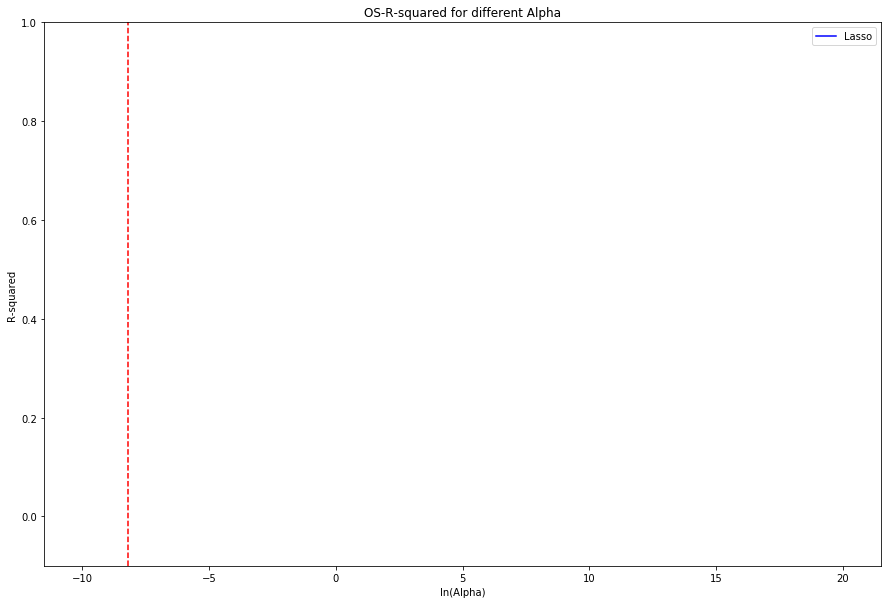

Optimal alpha for Lasso=0.000279692944919, best OS R_2=-0.271847767895


In [481]:
alphas = np.exp(np.linspace(-10.0,20.0,100)) 
for x in range(1,3):
  if x ==1:
    [alpha_optimalR, best_R2R, best_coefsR]=Regularization_fit_alpha(x,train.iloc[:,1:],train['Mean'],test.iloc[:,1:],test['Mean'],alphas,Graph=True,logl=True)
    print('Optimal alpha for Ridge={0}, best OS R_2={1}'.format(alpha_optimalR,best_R2R))
  else:
    [alpha_optimalL, best_R2L, best_coefsL]=Regularization_fit_alpha(x,train.iloc[:,1:],train['Mean'],test.iloc[:,1:],test['Mean'],alphas,Graph=True,logl=True)
    print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimalL,best_R2L))

In [483]:
Lasso=linear_model.Lasso(fit_intercept=True, alpha=alpha_optimalL)

Lasso.fit(train.iloc[:,1:],train['Mean'])
isample=Lasso.predict(train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(train['Mean'],isample)))

osample=Lasso.predict(test.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(test['Mean'],osample)))
Lasso.coef_[:10]

The IS R-squared of Lasso is: 0.974420228042
The OS R-squared of Lasso is: -0.271847767895


array([ 3.86575766e+04, -3.85459089e+02, -0.00000000e+00, -0.00000000e+00,
        2.26269435e+10,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [484]:
Ridge=linear_model.Ridge(fit_intercept=True, alpha=alpha_optimalR)
Ridge.fit(train.iloc[:,1:],train['Mean'])

isample=Ridge.predict(train.iloc[:,1:])
print("The IS R-squared of Ridge is: {0}".format(r2_score(train['Mean'],isample)))

osample=Ridge.predict(test.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(test['Mean'],osample)))
Ridge.coef_[:10]

The IS R-squared of Ridge is: 0.900952457299
The OS R-squared of Lasso is: -0.271847767895


array([ 4.35919315e+04,  2.36692784e+03,  3.37994428e+02,  3.58424317e+00,
        2.70454632e+03,  6.66567854e+01, -1.30253703e+01,  6.68167810e+02,
        3.45269904e+02,  3.45969349e+02])